In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import ImageOps, Image
import shutil
from sklearn.model_selection import train_test_split

### Data analysis

In [127]:
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
GRID_COLS = 3
GRID_ROWS = 3
print(f"cell size = {SCREEN_WIDTH/GRID_COLS}x{SCREEN_HEIGHT/GRID_ROWS}")

cell size = 640.0x360.0


In [128]:
# load database
df = pd.read_csv('../data_collection_phase/data/only_face.csv')
df.head()

,File Path Face Image,x,y
0,face_image_1.png,1143,912
1,face_image_2.png,1572,1063
2,face_image_3.png,499,51
3,face_image_4.png,1058,941
4,face_image_5.png,1413,819


In [129]:
df_class = df.copy()
df_class['cell'] = (df['x'] // (SCREEN_WIDTH/GRID_COLS)) + (df['y'] // (SCREEN_HEIGHT/GRID_ROWS)) * GRID_COLS
df_class['cell'] = df_class['cell'].astype(int)
df_class.head()

,File Path Face Image,x,y,cell
0,face_image_1.png,1143,912,7
1,face_image_2.png,1572,1063,8
2,face_image_3.png,499,51,0
3,face_image_4.png,1058,941,7
4,face_image_5.png,1413,819,8


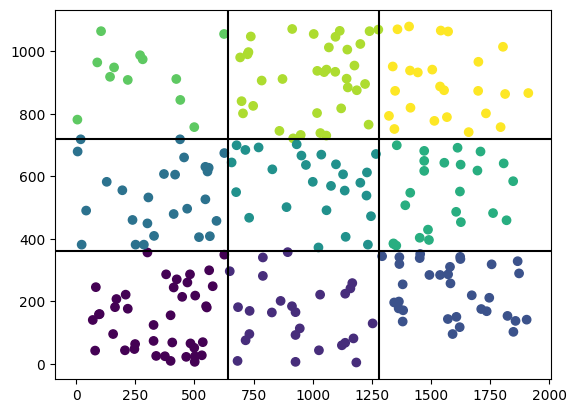

In [130]:
# plot points x,y on graph and color them based on cell
plt.scatter(df_class['x'], df_class['y'], c=df_class['cell'])
# add grid lines
for i in range(1, GRID_COLS):
    plt.axvline(i * (SCREEN_WIDTH/GRID_COLS), color='k')
for i in range(1, GRID_ROWS):
    plt.axhline(i * (SCREEN_HEIGHT/GRID_ROWS), color='k')
plt.show()

In [ ]:
# Load your dataframe
df = df_class  # Assuming df_classes is already loaded

# Define paths
data_dir = "../data_collection_phase/data/only_face"
output_dir = "dataset"  # Root folder for train/test dataset
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create train and test directories with subfolders for each class (0-24)
for split in ["train", "test"]:
    for label in range(GRID_COLS*GRID_ROWS):  # Labels from 0 to 24
        os.makedirs(os.path.join(output_dir, split, str(label)), exist_ok=True)

# Split data (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["cell"], random_state=42)

# Function to process and save images
def process_and_save_images(df_subset, split):
    for i in range(len(df_subset)):
        img_path = df_subset.iloc[i]['File Path Face Image']  # Filename
        full_path = os.path.join(data_dir, img_path)  # Full path
        label = str(df_subset.iloc[i]['cell'])  # Label as folder name

        if os.path.exists(full_path):  # Ensure file exists
            img = Image.open(full_path)
            face = img.crop((20, 40, 170, 85))  # Crop
            face = face.resize((150, 150))  # Resize to 224x224

            # Save in the appropriate train/test folder
            save_path = os.path.join(output_dir, split, label, f"{img_path}")
            face.save(save_path)

# Process training and testing images
process_and_save_images(train_df, "train")
process_and_save_images(test_df, "test")

print("Dataset successfully created with train and test splits!")

Dataset successfully created with train and test splits!


## Load data for tensorflow

In [132]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "dataset/train"
test_data_dir = "dataset/test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [133]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


Label : 0


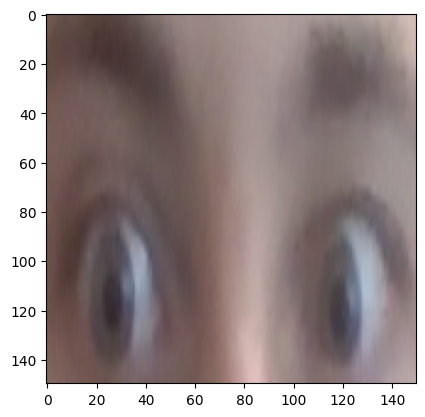

In [134]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [137]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 10
val_size = 50
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 146
Length of Validation Data : 50


In [138]:
#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

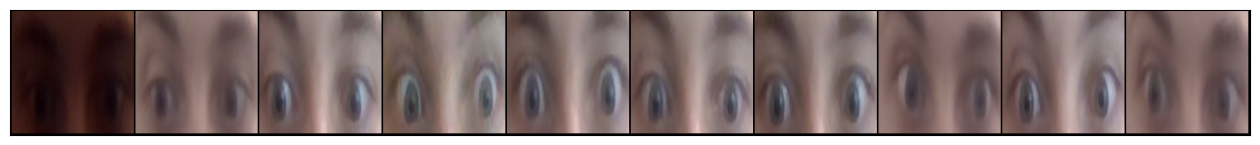

In [139]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

## Model

[resource](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48)

In [140]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [141]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [142]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [1]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.0001
#fitting the model on training data and record the result after each epoch
model = NaturalSceneClassification()
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

NameError: name 'torch' is not defined

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)